In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import tifffile
import numpy as np
from utils import *
import os
from pathlib import Path
import trackpy as tp

In [9]:
in_file = r"examples/20240206-114518_WT_aligned_drift_corrected.tif"

basename = os.path.basename(in_file)
out_dir = Path("./out/")
os.makedirs(out_dir, exist_ok=True)

In [10]:
take_only_walkers_on_fibre_trajectory(in_file, out_dir / basename)
basename_noext, ext = os.path.splitext(basename)

(9714, 174, 173, 3)


In [11]:
fit_method = "lq"
box_side_length = 5
drift = 0
min_gradient = 600

In [12]:
#os.environ['HDF5_DISABLE_VERSION_CHECK']='0'
#TOOD add out parameter
!python -m picasso localize {out_dir/basename} --fit-method {fit_method} --box-side-length {box_side_length}  --gradient {min_gradient} --drift {drift}



    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           out\20240206-114518_WT_aligned_drift_corrected.tif
3        box_side_length 5         
4        fit_method      lq        
5        gradient        600       
6        drift           0         
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='localize', 


LQ fitting: 100%|██████████| 900/900 [00:12<00:00, 72.76task/s] 


In [13]:
# Hack -- for now just rename the out file. This is dangerous in multithreaded environment.
out_locs = out_dir / (basename_noext + "_locs.hdf5")
new_suffix = f"__locs__fit_{fit_method}__box_{box_side_length}__gradient_{min_gradient}__drift_{drift}.hdf5"
new_suffix = (
    f"__locs_{fit_method}_box{box_side_length}_grad{min_gradient}_drift{drift}.hdf5"
)
new_out_locs = out_dir / (basename_noext + new_suffix)
print(new_out_locs)
out_locs.with_suffix(".yaml").rename(new_out_locs.with_suffix(".yaml"))
out_locs.rename(new_out_locs)

out\20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'out\\20240206-114518_WT_aligned_drift_corrected_locs.yaml' -> 'out\\20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.yaml'

In [15]:
max_link_displacement_px = 3
min_tray_length = 3

Frame 9713: 14 trajectories present.
mean drift  y   -23.668310
x     5.209506
dtype: float32
11450
Diff:  0.1611042861401866
NOT NORMAL AT 10.0%
Diff (in px^2/frame):  0.16110438108444214
Diff (in nm^2/s):  2931.372949055263
time per 1000nm (s):  170.56853859593076
mean step (nm/s): 93.89440476023577


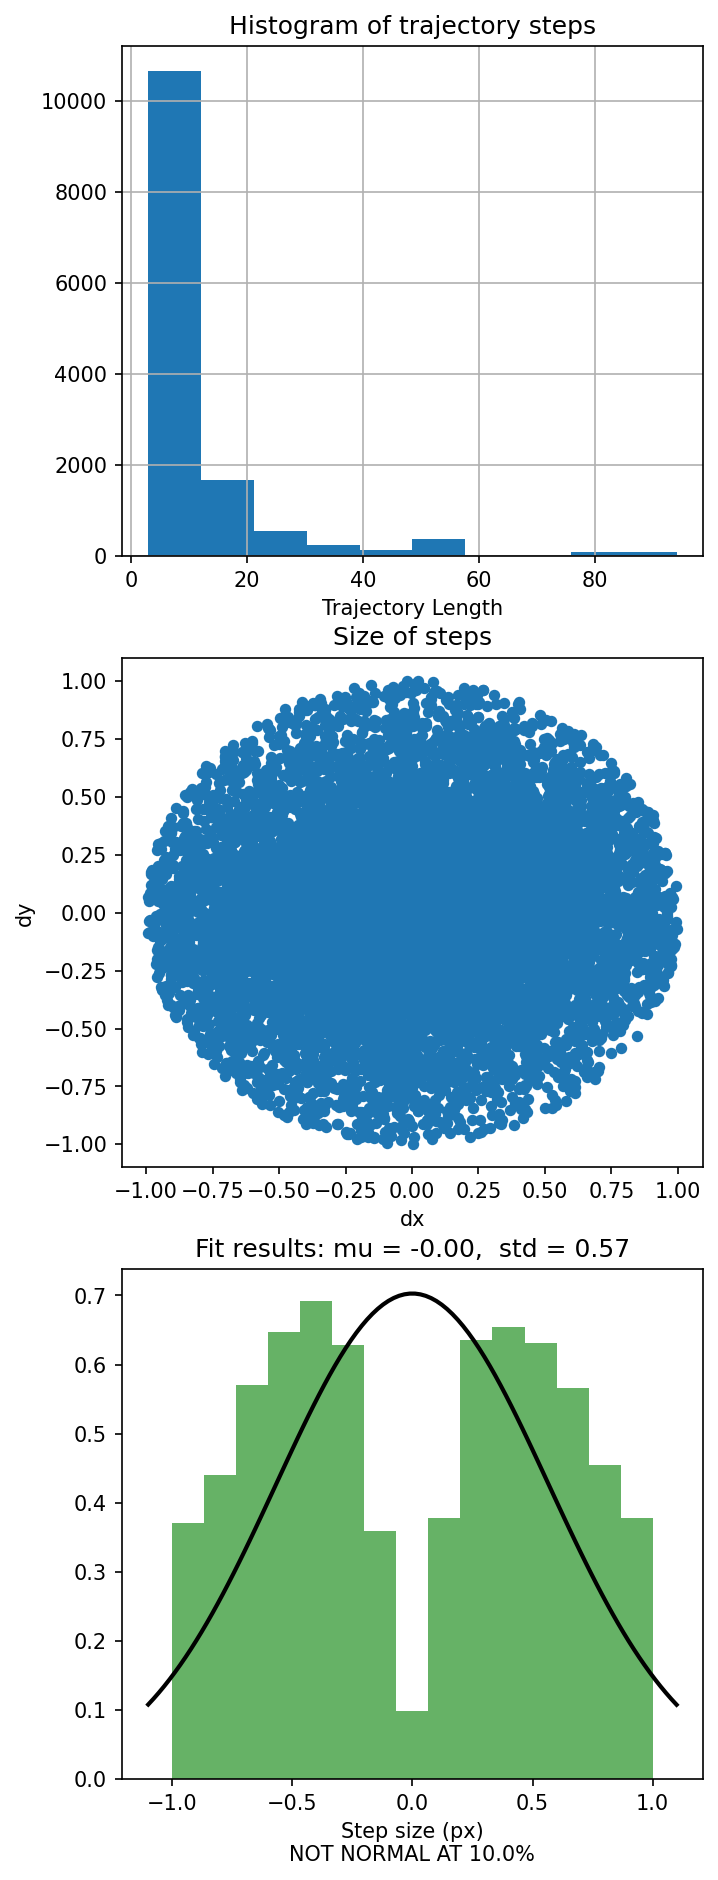

In [14]:
for max_link_displacement_px in [1]:
    locs = pd.read_hdf(new_out_locs, "locs")
    locs["mass"] = locs.photons

    tray = tp.link(locs, max_link_displacement_px)

    # count the length of trajectories
    tray_by_particle = tray.groupby(["particle"])
    tray["length"] = tray_by_particle["particle"].transform("count")

    # tray.length.hist()
    print("mean drift ", tp.compute_drift(tray).mean())

    # Exclude very short trays
    tray = tray.query(f"length>={min_tray_length}")

    steps = tray.groupby(["particle"]).apply(get_steps_from_df)
    steps["step_len"] = np.sqrt(steps.dx**2 + steps.dy**2)
    print(len(steps))

    suffix = f"__link{max_link_displacement_px}_traylen{min_tray_length}"
    base_linked_tray = Path(f'{new_out_locs.with_suffix("")}{suffix}')
    tray_out = base_linked_tray.with_suffix(".tray.csv.gz")
    tray.to_csv(tray_out)
    steps_out = base_linked_tray.with_suffix(".steps.csv.gz")
    steps.to_csv(steps_out)

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

    plt.sca(axes[0])
    tray.length.hist()
    plt.xlabel("Trajectory Length")
    plt.title("Histogram of trajectory steps")

    plt.sca(axes[1])
    steps.plot.scatter("dx", "dy", ax=axes[1])
    plt.title("Size of steps")

    plt.sca(axes[2])
    import numpy as np
    import scipy
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    step_len_signed = steps.step_len * np.random.choice((-1, 1), size=len(steps))
    # Generate some data for this demonstration.
    data = step_len_signed

    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)
    print("Diff: ", std**2 / 2)

    # Plot the histogram.
    plt.hist(data, bins=15, density=True, alpha=0.6, color="g")

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)

    plt.title(title)

    # perform Anderson-Darling Test
    from scipy.stats import anderson

    anderson_data = anderson(data)

    is_normal = anderson_data.statistic < anderson_data.critical_values[1]
    if not is_normal:
        normal_str = f"NOT NORMAL AT {anderson_data.significance_level[1]}%"
    else:
        normal_str = f"normal at {anderson_data.significance_level[1]}%"
    print(normal_str)
    plt.xlabel("Step size (px)\n" + normal_str)
    plt.savefig(base_linked_tray.with_suffix(".png"))

    info = {}
    info["diff_1D_px_px_frame"] = float(get_diff_from_steps(steps))
    print("Diff (in px^2/frame): ", info["diff_1D_px_px_frame"])

    px_to_nm = 110
    frame_to_s = 0.665

    info["diff_1D_nm_nm_s"] = (
        info["diff_1D_px_px_frame"] * px_to_nm * px_to_nm / frame_to_s
    )
    print("Diff (in nm^2/s): ", info["diff_1D_nm_nm_s"])
    info["time_per_1000nm_s"] = 1000 * 1000 / info["diff_1D_nm_nm_s"] / 2
    print("time per 1000nm (s): ", info["time_per_1000nm_s"])

    info["mean_step_nm_s"] = float(
        np.sqrt(2 * info["diff_1D_nm_nm_s"] * frame_to_s) / frame_to_s
    )
    print("mean step (nm/s):", info["mean_step_nm_s"])

    diff_info_out = base_linked_tray.with_suffix(".diff")

    info["normality_str"] = normal_str
    info["anderson_test"] = anderson_data

    write_yaml(info, diff_info_out)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.99225616, -0.96575714, -0.93925812, -0.91275909, -0.88626007,
        -0.85976105, -0.83326202, -0.806763  , -0.78026398, -0.75376495,
        -0.72726593, -0.70076691, -0.67426788, -0.64776886, -0.62126984,
        -0.59477081, -0.56827179, -0.54177277, -0.51527374, -0.48877472,
        -0.4622757 , -0.43577667, -0.40927765, -0.38277863, -0.3562796 ,
        -0.32978058, -0.30328156, -0.27678253, -0.25028351, -0.22378448,
        -0.19728546, -0.17078644, -0.14428741, -0.11778839, -0.09128937,
        -0.06479034, -0.03829132, -0.0117923 ,  0.01470673,  0.04120575,
         0.06770477,  0.0942038 ,  0.12070282,  0.14720184,  0.17370087,
         0.20019989,  0.22669891,  0.25319794,  0.27969696,  0.30619598,
         0.33269501, 

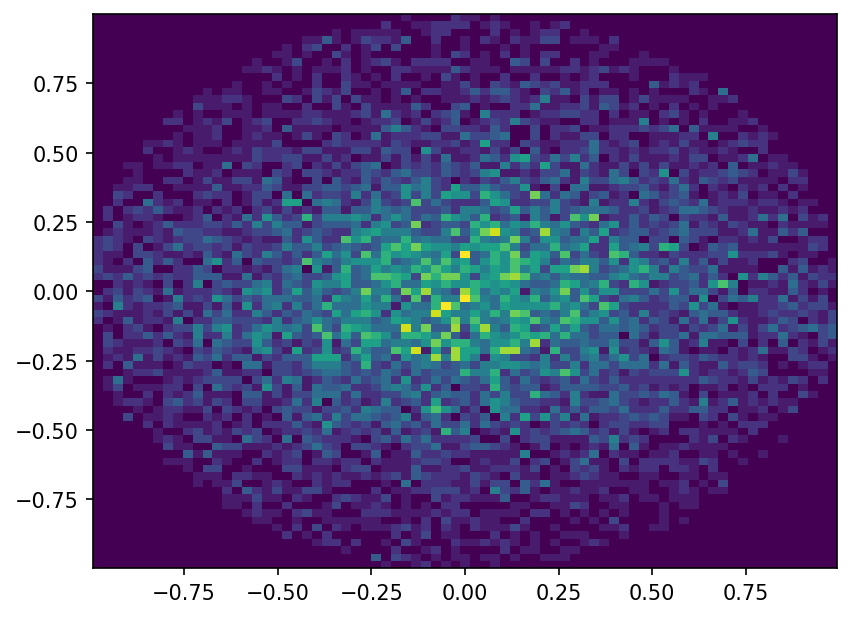

In [18]:
plt.hist2d(steps.dx, steps.dy, bins=75)

In [21]:
def fit_2d_normal(self, x, fix_mean=None, fix_cov=None):
        """Fit a multivariate normal distribution to data.

        Parameters
        ----------
        x : ndarray (m, n)
            Data the distribution is fitted to. Must have two axes.
            The first axis of length `m` represents the number of vectors
            the distribution is fitted to. The second axis of length `n`
            determines the dimensionality of the fitted distribution.
        fix_mean : ndarray(n, )
            Fixed mean vector. Must have length `n`.
        fix_cov: ndarray (n, n)
            Fixed covariance matrix. Must have shape `(n, n)`.

        Returns
        -------
        mean : ndarray (n, )
            Maximum likelihood estimate of the mean vector
        cov : ndarray (n, n)
            Maximum likelihood estimate of the covariance matrix

        """
        # input validation for data to be fitted
        x = np.asarray(x)
        if x.ndim != 2:
            raise ValueError("`x` must be two-dimensional.")

        n_vectors, dim = x.shape

        # parameter estimation
        # reference: https://home.ttic.edu/~shubhendu/Slides/Estimation.pdf
        if fix_mean is not None:
            # input validation for `fix_mean`
            fix_mean = np.atleast_1d(fix_mean)
            if fix_mean.shape != (dim, ):
                msg = ("`fix_mean` must be a one-dimensional array the same "
                       "length as the dimensionality of the vectors `x`.")
                raise ValueError(msg)
            mean = fix_mean
        else:
            mean = x.mean(axis=0)

        if fix_cov is not None:
            # input validation for `fix_cov`
            fix_cov = np.atleast_2d(fix_cov)
            # validate shape
            if fix_cov.shape != (dim, dim):
                msg = ("`fix_cov` must be a two-dimensional square array "
                       "of same side length as the dimensionality of the "
                       "vectors `x`.")
                raise ValueError(msg)
            # validate positive semidefiniteness
            # a trimmed down copy from _PSD
            s, u = scipy.linalg.eigh(fix_cov, lower=True, check_finite=True)
            eps = _eigvalsh_to_eps(s)
            if np.min(s) < -eps:
                msg = "`fix_cov` must be symmetric positive semidefinite."
                raise ValueError(msg)
            cov = fix_cov
        else:
            centered_data = x - mean
            cov = centered_data.T @ centered_data / n_vectors
        return mean, cov

In [28]:
hist, x_edges, y_edges = np.histogram2d(steps.dx, steps.dy, bins=75)

In [32]:
from scipy.stats import multivariate_normal 
mean, cov = multivariate_normal.fit(np.array([steps.dx, steps.dy]).T)
normal_dist = multivariate_normal(mean, cov)

In [67]:
normal_dist.pdf([0,0])

eigen_values, eigen_vectors = np.linalg.eig(cov)

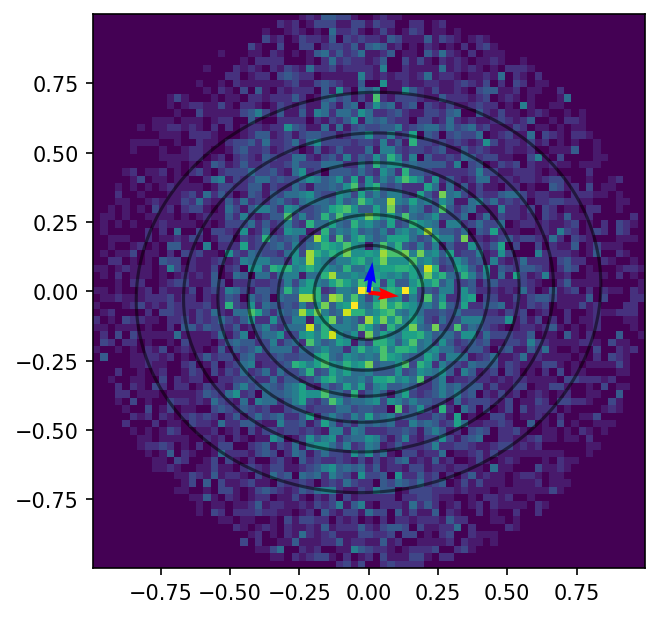

In [76]:
#dist = (multivariate_normal)

x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
x_mesh, y_mesh = np.meshgrid(x_centers, y_centers)  # Creates two 2D arrays
xy_combined = np.array([x_mesh.ravel(), y_mesh.ravel()]).T


plt.imshow(hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower')
plt.contour(x_mesh, y_mesh, normal_dist.pdf(xy_combined).reshape(75, 75), colors='k', alpha=0.5)
plt.quiver(mean[0], mean[1], eigen_vectors[0,0], eigen_vectors[0,1], color='red')
plt.quiver(mean[0], mean[1], eigen_vectors[1,0], eigen_vectors[1,1], color='blue')

In [61]:
cov

array([[0.18487637, 0.00619239],
       [0.00619239, 0.13731447]], dtype=float32)

In [78]:
tray

,frame,x,y,photons,sx,sy,bg,lpx,lpy,ellipticity,net_gradient,mass,particle,length
0,0,91.213867,65.744408,9388.701172,2.911515,2.981544,-67.923668,0.020089,0.016721,0.023487,875.481995,9388.701172,0,4
1,0,93.437996,77.745689,8742.836914,2.439063,2.197127,-20.471554,0.044310,0.040896,0.099192,2371.315430,8742.836914,1,57
2,0,96.588409,89.335663,1607.129272,1.400918,2.053622,70.709206,0.101421,0.186994,0.317830,1119.201416,1607.129272,2,8
3,1,90.618370,65.327332,8479.042969,3.160187,2.620618,-42.325974,0.034955,0.038536,0.170740,915.476746,8479.042969,0,4
4,1,92.999649,77.431053,6330.429199,2.229054,2.031210,41.463661,0.064536,0.057320,0.088757,2667.841309,6330.429199,1,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32656,9692,96.232109,87.616402,6282.102539,2.203727,2.410241,49.924080,0.065935,0.074451,0.085682,1183.339111,6282.102539,19265,3
32664,9693,95.864388,87.029381,573.642334,1.133107,0.694888,139.236816,0.219624,0.101626,0.386741,1185.386719,573.642334,19265,3
32676,9694,95.171631,84.187500,434.349060,0.500814,1.440099,151.966949,0.085183,0.453960,0.652236,1136.683472,434.349060,19289,3
32684,9695,95.114067,83.321991,470.375519,0.586623,0.743665,117.515511,0.090052,0.124988,0.211173,941.160828,470.375519,19289,3


In [77]:
steps

dframe        dx        dy  step_len
particle                                        
0        0       1 -0.595497 -0.417076  0.727028
         1       1  0.387215  0.355324  0.525538
         2       1  0.264595  0.401665  0.480983
1        0       1 -0.438347 -0.314636  0.539578
         1       1  0.402908  0.086189  0.412024
...            ...       ...       ...       ...
19164    1       1 -0.011658  0.299171  0.299398
19265    0       1  0.544922  0.047661  0.547002
         1       1 -0.367722 -0.587021  0.692685
19289    0       1 -0.057564 -0.865509  0.867421
         1       1  0.350937  0.320419  0.475211

[11450 rows x 4 columns]

In [66]:
mat 

0.0

In [65]:
VAL = np.diag(eigen_values)
V = eigen_vectors
V_inv = np.linalg.inv(V)
V@VAL@V_inv

array([[0.18487635, 0.00619239],
       [0.00619239, 0.13731445]], dtype=float32)